O Brasil é um país de dimensões continentais e amplas desigualdades regionais, por isso, além de utilizar clusterização, é importabte entender as desigualdades regionais dentro de cluster que agrupam cidade levando em consideração características demográficas parecidas.
___

In [350]:
# Silent Warnings
import warnings
warnings.filterwarnings('ignore')

In [351]:
# Importing libraries
import pandas as pd
#from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datetime import datetime
import seaborn as sns
import numpy as np
import duckdb
import my_functions as mf

In [352]:
pd.set_option('display.max_columns', None)

In [353]:
# import locale

# # Set the Brazilian locale
# locale.setlocale(locale.LC_NUMERIC, 'pt_BR.UTF-8')

# 1. Data Transformation, Exploration, and Analysis

# Database

    The dataset contains socio-demographic and firmographic features for 530 cities over a period of 7 months.
___

In [354]:
# Organizing key information within each dataset

chs = pd.read_csv('data/chs.csv')
chs.columns = chs.columns.str.lower()
chs["uf"] = chs['cidade-uf'].str[-2:]
chs["cidade-uf"] = chs['cidade-uf'].str[:-3]
chs["chs"] = chs['chs'].str[:-1]
chs["chs"] = chs["chs"].str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)
chs.rename(columns={'cidade-uf': 'cidade', 'mes/ano':'mes_ano'}, inplace=True)

churn = pd.read_csv('data/churn.csv')
churn.columns = churn.columns.str.lower()
churn["churn"] = churn['churn'].str[:-1]
churn["churn"] = churn["churn"].str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)
churn.rename(columns={'mes/ano':'mes_ano'}, inplace=True)

mub = pd.read_csv('data/mub2.csv', sep=';')
mub.columns = mub.columns.str.lower()
mub.rename(columns={'mes/ano':'mes_ano',
                    'Cidade':'cidade'}, inplace=True)

pedidos = pd.read_csv('data/pedidos.csv')
pedidos.columns = pedidos.columns.str.lower()
pedidos["pedidos"] = pedidos["pedidos"].str.replace('.', '')
pedidos['pedidos'] = pd.to_numeric(pedidos['pedidos'], errors='coerce')
pedidos.rename(columns={'mes/ano':'mes_ano'}, inplace=True)

reativacao = pd.read_csv('data/reativacao.csv')
reativacao.columns = reativacao.columns.str.lower()
reativacao["reativacao"] = reativacao['reativacao'].str[:-1]
reativacao["reativacao"] = reativacao["reativacao"].str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)
reativacao.rename(columns={'mes/ano':'mes_ano'}, inplace=True)

restaurantes = pd.read_csv('data/restaurantes.csv')
restaurantes.columns = restaurantes.columns.str.lower()
restaurantes["uf"] = restaurantes['cidade-uf'].str[-2:]
restaurantes["cidade-uf"] = restaurantes['cidade-uf'].str[:-3]
restaurantes.rename(columns={'cidade-uf': 'cidade', 'mes/ano':'mes_ano'}, inplace=True)

sociodemografica = pd.read_csv('data/sociodemografica2.csv', sep=";")
sociodemografica.columns = sociodemografica.columns.str.lower()
sociodemografica["uf"] = sociodemografica['cidade'].str[-2:]
sociodemografica["cidade"] = sociodemografica['cidade'].str[:-3]


In [355]:
df = \
duckdb.query("select a.*,\
                     b.churn,\
                     c.mub,\
                     d.pedidos,\
                     e.reativacao,\
                     f.restaurantes,\
                     g.renda_media,\
                     g.populacao,\
                     g.leads_total\
                from chs a\
           left join churn b\
                  on a.uf = b.uf and a.mes_ano = b.mes_ano and a.cidade = b.cidade\
           left join mub c\
                  on a.uf = c.uf and a.mes_ano = c.mes_ano and a.cidade = c.cidade\
           left join pedidos d\
                  on a.uf = d.uf and a.mes_ano = d.mes_ano and a.cidade = d.cidade\
           left join reativacao e\
                  on a.uf = e.uf and a.mes_ano = e.mes_ano and a.cidade = e.cidade\
           left join restaurantes f\
                  on a.uf = f.uf and a.mes_ano = f.mes_ano and a.cidade = f.cidade\
           left join sociodemografica g\
                  on a.uf = g.uf and a.cidade = g.cidade").to_df()

In [356]:
# Convert to datetime and format as yyyy-mm
df['mes_ano'] = pd.to_datetime(df['mes_ano'], format='%d/%m/%Y').dt.to_period('M').astype(str)

    Creating a Region Variable

In [357]:
# Mapping of 'uf' to regions
uf_to_region = {
    # North
    'AC': 'NORTE', 'AP': 'NORTE', 'AM': 'NORTE', 'PA': 'NORTE', 'RO': 'NORTE', 'RR': 'NORTE', 'TO': 'NORTE',
    # Northeast
    'AL': 'NORDESTE', 'BA': 'NORDESTE', 'CE': 'NORDESTE', 'MA': 'NORDESTE', 'PB': 'NORDESTE', 'PE': 'NORDESTE', 'PI': 'NORDESTE', 'RN': 'NORDESTE', 'SE': 'NORDESTE',
    # Southeast
    'ES': 'SUDESTE', 'MG': 'SUDESTE', 'RJ': 'SUDESTE', 'SP': 'SUDESTE',
    # South
    'PR': 'SUL', 'RS': 'SUL', 'SC': 'SUL',
    # Central-West
    'DF': 'CENTRO-OESTE', 'GO': 'CENTRO-OESTE', 'MT': 'CENTRO-OESTE', 'MS': 'CENTRO-OESTE'
}

# Add region column
df['region'] = df['uf'].map(uf_to_region)


In [358]:
# Restaurantes ativos
df['cobertura_delivery'] = round((df['mub'] / df['populacao'])*100,1)

# Passo 1

> Qual é o número de restaurantes (absoluto) que foram reativados por mês?

To calculate the number of reactivated restaurants (RR), we can just multiply restaurante x reativacao

$$ RR = \ \text{restaurante} \cdot \text{reativacao} \ $$

In [359]:
# Restaurantes ativos
df['restaurantes_reativados'] = (df['restaurantes'] * df['reativacao']/100).astype(int)
# Taxa de churn e reativação já estão no dfset


In [360]:
rr = df.groupby('mes_ano')['restaurantes_reativados'].agg('sum')

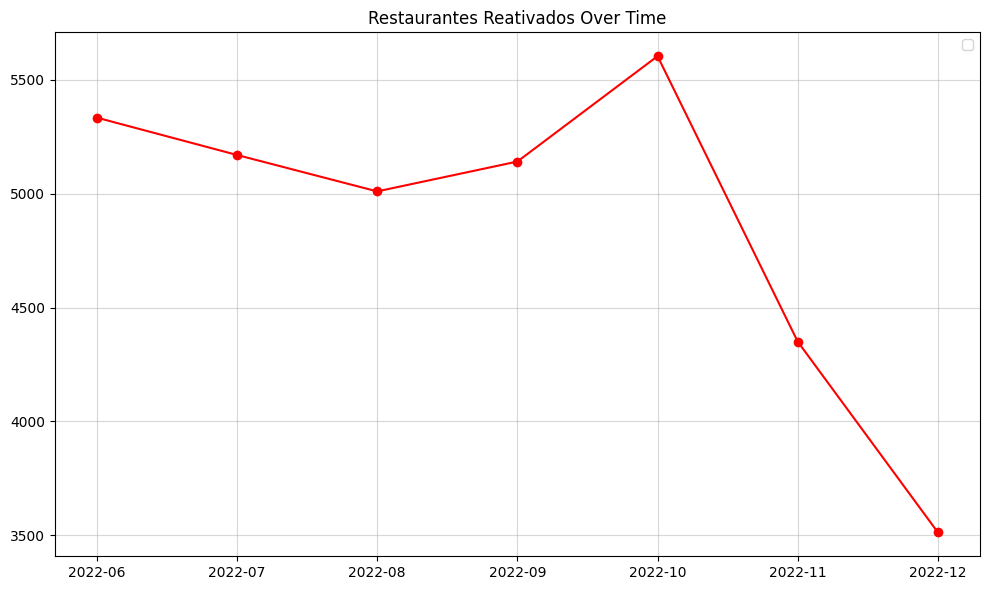

In [361]:
# Plot the red line chart
plt.figure(figsize=(10, 6))
plt.plot(rr.index, rr.values, color='red', marker='o', linestyle='-')
plt.title('Restaurantes Reativados Over Time')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0)
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [362]:
rr_region = df.groupby(['mes_ano', 'region'])['restaurantes_reativados'].agg('sum')

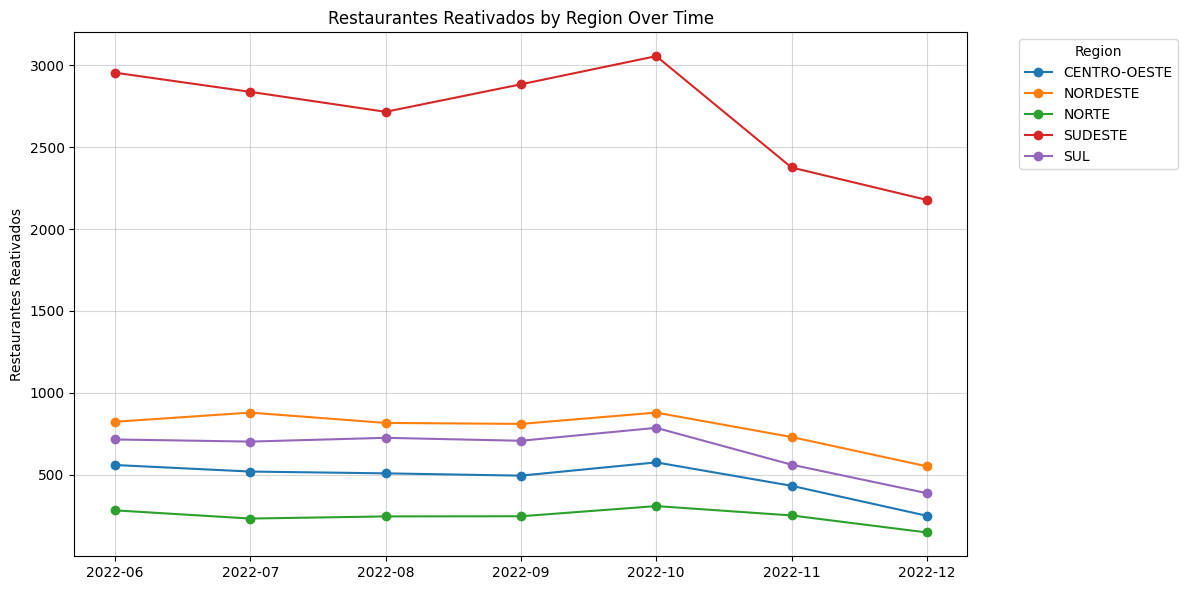

In [363]:
import matplotlib.pyplot as plt

# Group and aggregate the data
rr_region = df.groupby(['mes_ano', 'region'])['restaurantes_reativados'].agg('sum').reset_index()

# Pivot the data to have regions as columns for easier plotting
pivot_data = rr_region.pivot(index='mes_ano', columns='region', values='restaurantes_reativados')

# Plot the line chart for each region
plt.figure(figsize=(12, 6))
for region in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[region], marker='o', label=region)

# Add titles and labels
plt.title('Restaurantes Reativados by Region Over Time')
plt.xlabel('')
plt.ylabel('Restaurantes Reativados')
plt.xticks(rotation=0)
plt.grid(alpha=0.5)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot
plt.tight_layout()
plt.show()


> Qual é o número de restaurantes (absoluto) que deram churn por mês?

To calculate the number of Restaurantes Sem Pedido (RSP), we need the % of resturants in churn and the number of Restaurantes Com Pedido (restaurantes)

$$ RSP = \frac{restaurantes \cdot \text{churn}}{1 - \text{churn}} $$

In [364]:
# Restaurantes que deram churn
df['restaurantes_churn'] = ((df['restaurantes'] * df['churn']/100)/(1-df['churn']/100)).astype(int)


In [365]:
rsp = df.groupby('mes_ano')['restaurantes_churn'].agg('sum')

In [367]:
# import pandas as pd

# # Grouped data converted to DataFrames
populacao_agg = df.groupby('mes_ano')['populacao'].agg('sum').reset_index()
mub_agg = df.groupby('mes_ano')['mub'].agg('sum').reset_index()
restaurantes_agg = df.groupby('mes_ano')['restaurantes'].agg('sum').reset_index()
leads_total_agg = df.groupby('mes_ano')['leads_total'].agg('sum').reset_index()
pedidos_agg = df.groupby('mes_ano')['pedidos'].agg('sum').reset_index()

# # Perform left joins step by step
result = populacao_agg.merge(mub_agg, on='mes_ano', how='left')
result = result.merge(restaurantes_agg, on='mes_ano', how='left')
result = result.merge(leads_total_agg, on='mes_ano', how='left')
result = result.merge(pedidos_agg, on='mes_ano', how='left')

# # Display the resulting DataFrame
result


,mes_ano,populacao,mub,restaurantes,leads_total,pedidos
0,2022-06,117860086,7379999,152692,3533046,24907734
1,2022-07,117860086,7640321,153274,3533046,25436094
2,2022-08,117860086,7506525,154481,3533046,24220605
3,2022-09,117860086,7920924,155965,3533046,25334610
4,2022-10,117860086,7683129,157925,3533046,26295980
5,2022-11,117860086,7804866,157031,3533046,26206926
6,2022-12,117860086,7990388,153248,3533046,26519684


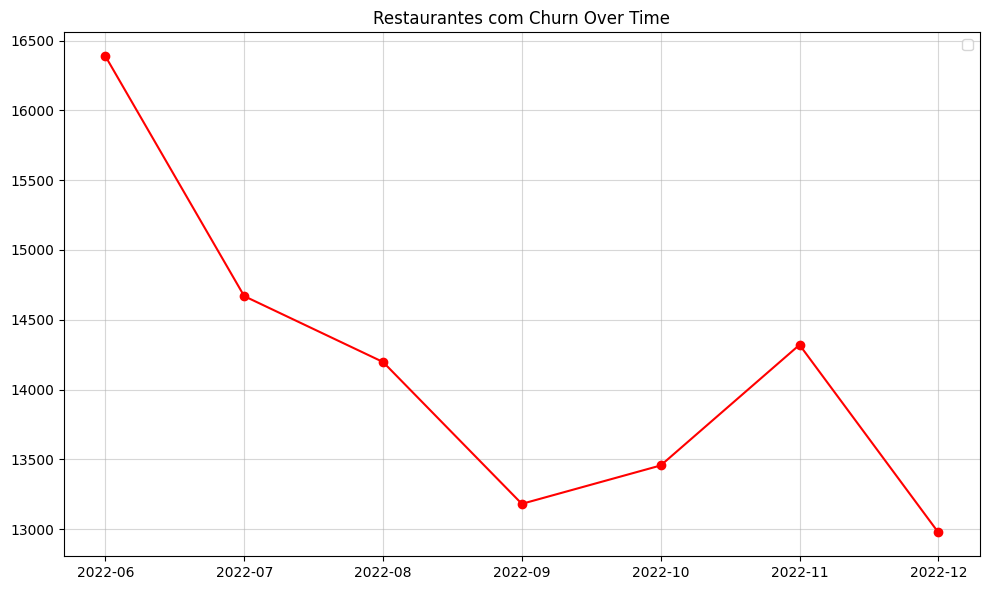

In [368]:
# Plot the red line chart
plt.figure(figsize=(10, 6))
plt.plot(rsp.index, rsp.values, color='red', marker='o', linestyle='-')
plt.title('Restaurantes com Churn Over Time')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0)
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

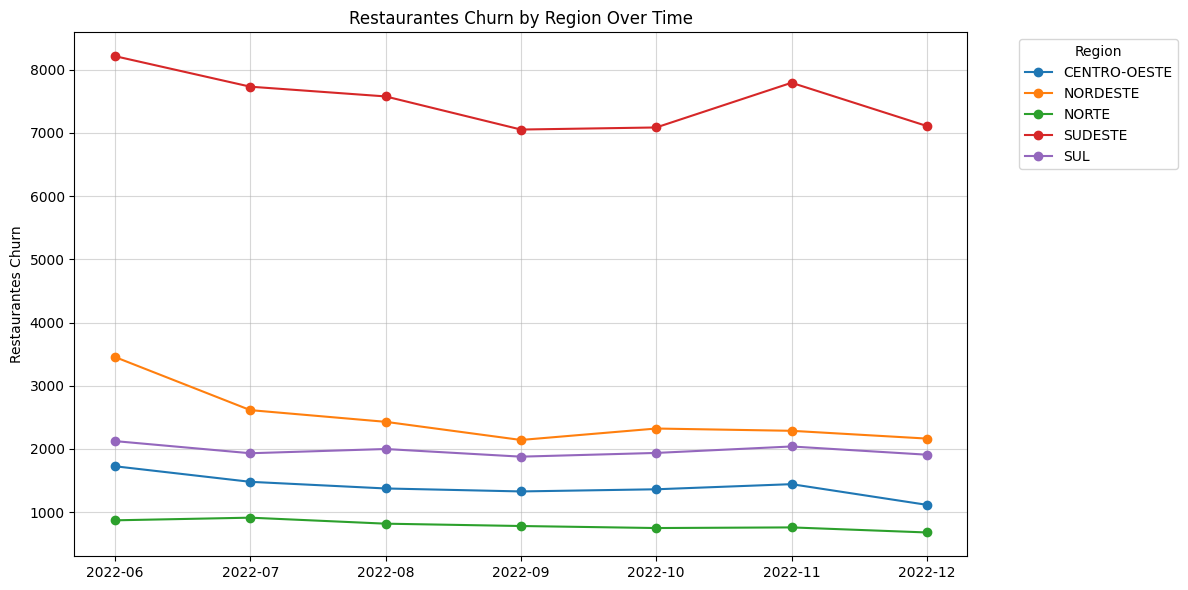

In [369]:
import matplotlib.pyplot as plt

# Group and aggregate the data
rsp_region = df.groupby(['mes_ano', 'region'])['restaurantes_churn'].agg('sum').reset_index()

# Pivot the data to have regions as columns for easier plotting
pivot_data = rsp_region.pivot(index='mes_ano', columns='region', values='restaurantes_churn')

# Plot the line chart for each region
plt.figure(figsize=(12, 6))
for region in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[region], marker='o', label=region)

# Add titles and labels
plt.title('Restaurantes Churn by Region Over Time')
plt.xlabel('')
plt.ylabel('Restaurantes Churn')
plt.xticks(rotation=0)
plt.grid(alpha=0.5)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot
plt.tight_layout()
plt.show()


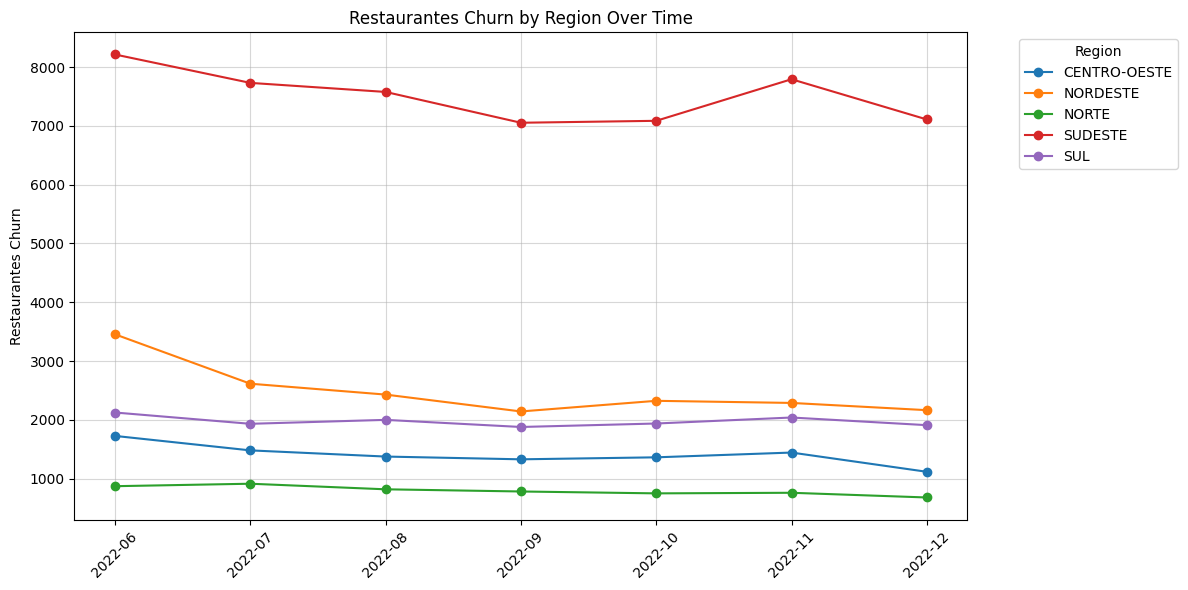

In [370]:
import matplotlib.pyplot as plt

# Group and aggregate the data
rsp_region = df.groupby(['mes_ano', 'region'])['restaurantes_churn'].agg('sum').reset_index()

# Pivot the data to have regions as columns for easier plotting
pivot_data = rsp_region.pivot(index='mes_ano', columns='region', values='restaurantes_churn')

# Plot the line chart for each region
plt.figure(figsize=(12, 6))
for region in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[region], marker='o', label=region)

# Add titles and labels
plt.title('Restaurantes Churn by Region Over Time')
plt.xlabel('')
plt.ylabel('Restaurantes Churn')
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot
plt.tight_layout()
plt.show()


> Qual é o número de restaurantes ativos por mês?


In [371]:
df.groupby('mes_ano')['restaurantes'].agg('sum')

mes_ano
2022-06    152692
2022-07    153274
2022-08    154481
2022-09    155965
2022-10    157925
2022-11    157031
2022-12    153248
Name: restaurantes, dtype: int64

> Qual é a média de mub no primeiro quartil? 

In [372]:
# Calculate the first quartile limit
q1 = df['mub'].quantile(0.25)

# Filter data to include only values on first quartile
mub_q1 = df[df['mub'] <= q1]

# Calculate the average of mub for the first quartile limit
media_mub_q1 = round(mub_q1['mub'].mean())

print(f"Média de MUB no primeiro quartil: {media_mub_q1}")

Média de MUB no primeiro quartil: 811


> Qual é a média de pedidos no terceiro quartil do mub?

In [373]:
# Calculate the third quartile limit
q3 = df['mub'].quantile(0.75)

# Filter data to include only values on first quartile
mub_q1 = df[df['mub'] > q3]

# Calculate the average of pedidos for the third quartile of mub
media_mub_q1 = round(mub_q1['pedidos'].mean())

print(f"Média de pedidos no terceiro quartil do mub: {media_mub_q1}")

Média de pedidos no terceiro quartil do mub: 164265


# Passo 2

> Existe alguma correlação entre pedidos e número de restaurantes?

In [374]:
# Calcular a correlação entre pedidos e número de restaurantes
correlacao = df['pedidos'].corr(df['restaurantes'])

print(f"Correlação entre pedidos e número de restaurantes: {correlacao}")

Correlação entre pedidos e número de restaurantes: 0.9924591801362665


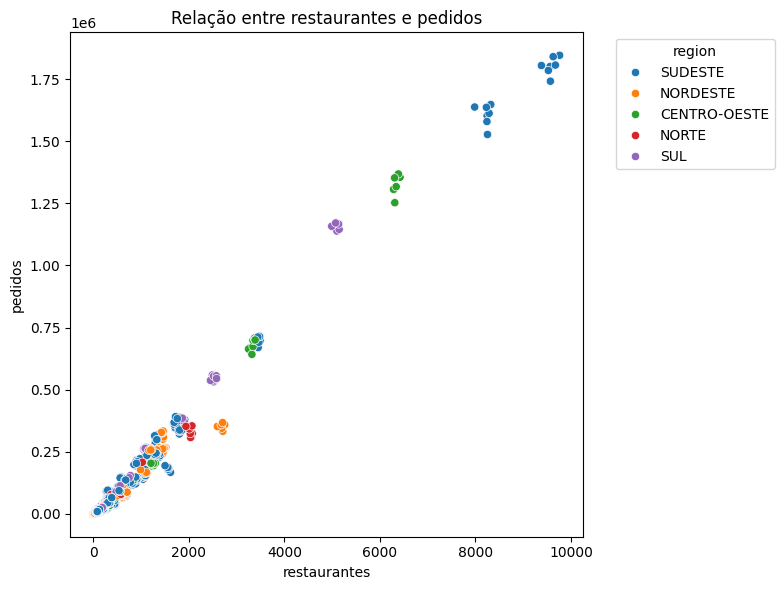

In [375]:
mf.plot_scatter(data=df, x='restaurantes', y='pedidos', hue="region")

There is a strong correlation between Número de Restaurantes e Total de Pedidos
___

> Existe alguma correlação entre a renda média da região e o mub?

In [376]:
# Calcular a correlação entre pedidos e número de restaurantes
correlacao = df['mub'].corr(df['renda_media'])

print(f"Correlação entre pedidos e número de restaurantes: {correlacao}")

Correlação entre pedidos e número de restaurantes: 0.384768227949471


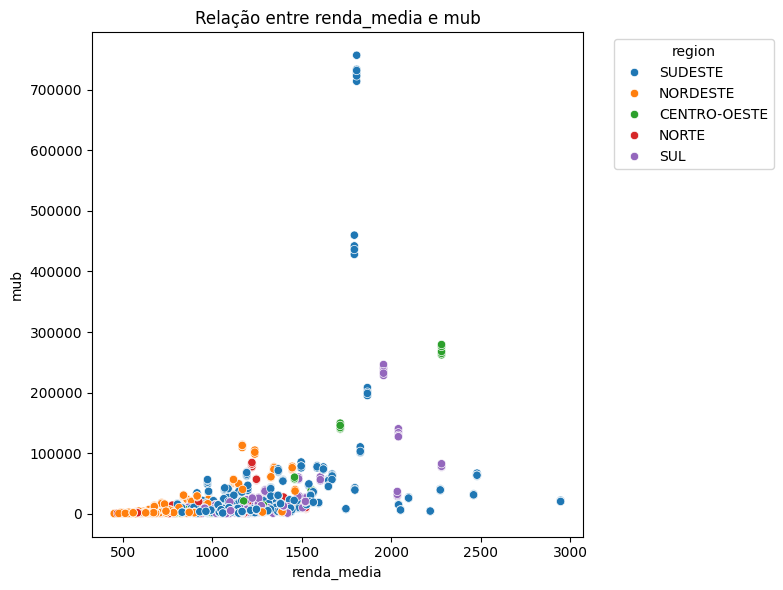

In [377]:
mf.plot_scatter(data=df, x='renda_media', y='mub', hue="region")

# Passo 3

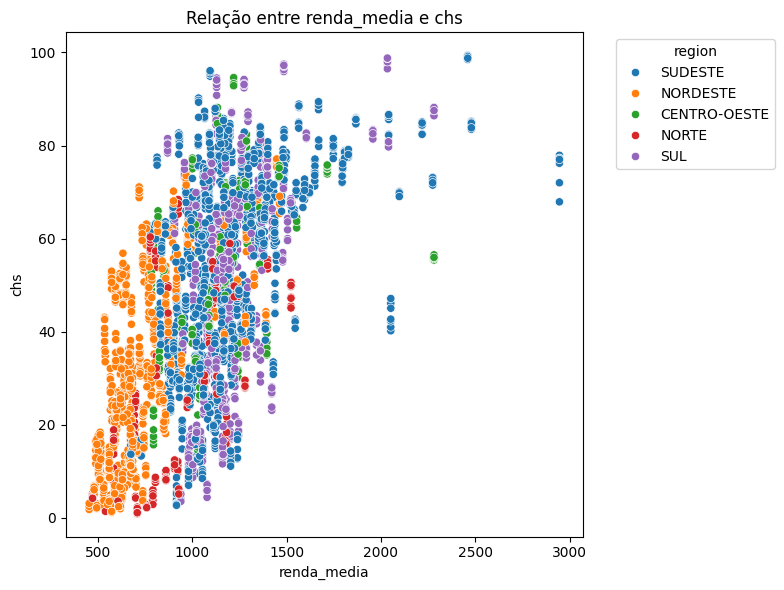

In [379]:
mf.plot_scatter(df, x='renda_media', y='chs', hue='region')

There are some cities in the South (SUL) and Southeast (SUDESTE) regions that have twice the income of cities in the Northeast (NORDESTE), yet they have the same coverage as the latter.
___

    Renda Média x Pedidos

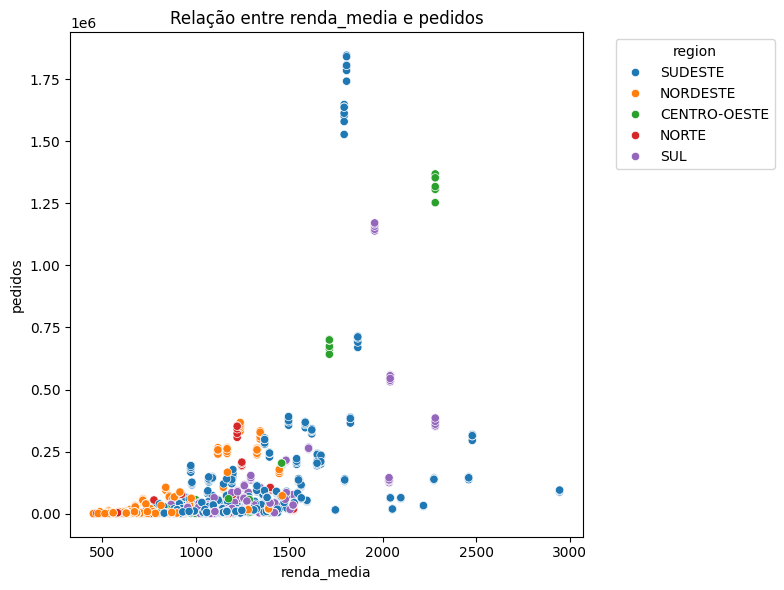

In [380]:
mf.plot_scatter(data=df, x='renda_media', y='pedidos', hue='region')

    % de Restaurantes ativos para comparar com CHS

In [381]:
df['restaurantes_ativos'] = round((df['restaurantes'] + df['restaurantes_churn'])/df['leads_total']*100, 1)

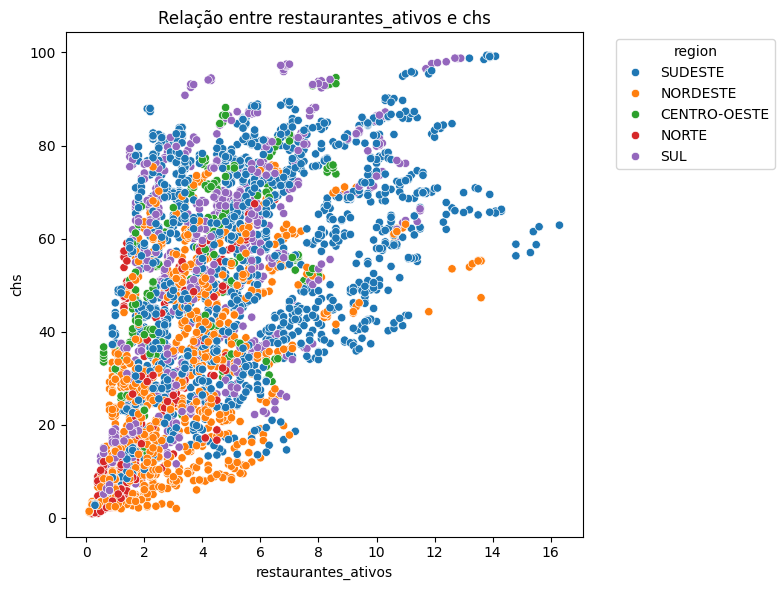

In [382]:
mf.plot_scatter(data=df, x='restaurantes_ativos', y='chs', hue='region')

The higher the rate of active restaurants (restaurantes_ativos), the higher the percentage of the population covered (chs)
___

    Mean or Median?

We'll use median because we have some extreme values that could polute our mean.

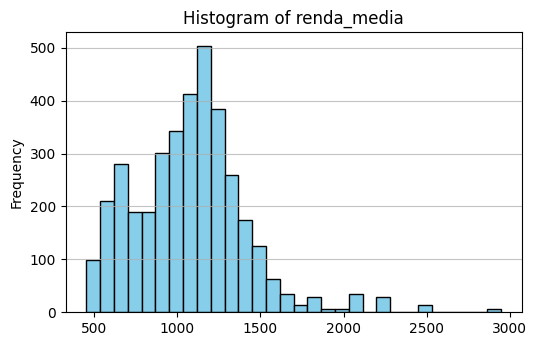

In [383]:
mf.plot_hist(df, 'renda_media')

In [384]:
mf.check_outliers(df)

,count,mean,std,min,25%,50%,75%,max,IQR,BotOutlier,TopOutlier,CheckBotOut,CheckTopOut
chs,3710.0,47.0,24.2,0.9,28.0,48.5,67.2,99.4,39.2,-30.80,126.00,No,No
churn,3710.0,9.7,5.5,0.0,6.8,8.7,11.2,90.0,4.4,0.20,17.80,Yes,Yes
mub,3710.0,14535.4,43888.8,29.0,1667.2,4575.0,12201.8,757117.0,10534.6,-14134.70,28003.70,No,Yes
pedidos,3710.0,48226.9,147852.6,30.0,3324.5,10681.5,35544.8,1846316.0,32220.3,-45005.95,83875.25,No,Yes
reativacao,3710.0,3.2,2.4,0.0,1.9,3.0,4.2,50.0,2.3,-1.55,7.65,No,Yes
restaurantes,3710.0,292.3,743.7,2.0,46.0,100.0,256.0,9762.0,210.0,-269.00,571.00,No,Yes
renda_media,3710.0,1077.7,339.3,453.0,850.0,1080.0,1249.0,2946.0,399.0,251.50,1847.50,No,Yes
populacao,3710.0,222377.5,585456.6,50071.0,69407.0,101415.5,196935.0,10481993.0,127528.0,-121885.00,388227.00,No,Yes
leads_total,3710.0,6666.1,19621.6,0.0,1762.0,2849.0,5681.0,359982.0,3919.0,-4116.50,11559.50,No,Yes
cobertura_delivery,3710.0,5.0,3.8,0.0,2.2,4.3,6.9,36.7,4.7,-4.85,13.95,No,Yes


In [385]:
# Replace infinite values with NaN to make filtering easier
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN (which now includes rows with inf or -inf)
df = df.dropna()

We removed one city from the dataset because it contained inf values in the restaurantes_ativos variable.

In [386]:
mf.check_outliers(df)

,count,mean,std,min,25%,50%,75%,max,IQR,BotOutlier,TopOutlier,CheckBotOut,CheckTopOut
chs,3703.0,47.1,24.1,0.9,28.1,48.6,67.3,99.4,39.2,-30.70,126.10,No,No
churn,3703.0,9.7,5.5,0.0,6.8,8.7,11.2,90.0,4.4,0.20,17.80,Yes,Yes
mub,3703.0,14562.2,43925.9,29.0,1675.5,4593.0,12219.0,757117.0,10543.5,-14139.75,28034.25,No,Yes
pedidos,3703.0,48317.6,147977.6,30.0,3349.0,10700.0,35638.5,1846316.0,32289.5,-45085.25,84072.75,No,Yes
reativacao,3703.0,3.3,2.4,0.0,1.9,3.0,4.2,50.0,2.3,-1.55,7.65,No,Yes
restaurantes,3703.0,292.9,744.3,2.0,46.0,100.0,257.0,9762.0,211.0,-270.50,573.50,No,Yes
renda_media,3703.0,1078.4,339.2,453.0,857.0,1081.0,1249.0,2946.0,392.0,269.00,1837.00,No,Yes
populacao,3703.0,222698.3,585963.3,50071.0,69434.0,101511.0,196935.0,10481993.0,127501.0,-121817.50,388186.50,No,Yes
leads_total,3703.0,6678.7,19638.0,381.0,1764.0,2852.0,5681.0,359982.0,3917.0,-4111.50,11556.50,No,Yes
cobertura_delivery,3703.0,5.0,3.8,0.0,2.2,4.3,6.9,36.7,4.7,-4.85,13.95,No,Yes


    Calculating median and rerunnning the describe table

In [387]:
df_median = df.loc[:, df.columns != 'mes_ano'].groupby(['cidade','uf','region']).agg('median').reset_index()

In [388]:
mf.check_outliers(df_median)

,count,mean,std,min,25%,50%,75%,max,IQR,BotOutlier,TopOutlier,CheckBotOut,CheckTopOut
chs,529.0,47.2,24.2,1.2,28.7,48.8,67.3,99.1,38.6,-29.20,125.20,No,No
churn,529.0,9.3,3.0,0.0,7.3,8.8,10.6,24.1,3.3,2.35,15.55,Yes,Yes
mub,529.0,14554.8,43762.7,46.0,1708.0,4666.0,12140.0,726914.0,10432.0,-13940.00,27788.00,No,Yes
pedidos,529.0,48399.7,148227.3,55.0,3449.0,10682.0,36012.0,1805036.0,32563.0,-45395.50,84856.50,No,Yes
reativacao,529.0,3.0,1.5,0.0,2.2,3.0,3.8,16.7,1.6,-0.20,6.20,No,Yes
restaurantes,529.0,293.2,744.6,2.0,46.0,102.0,256.0,9569.0,210.0,-269.00,571.00,No,Yes
renda_media,529.0,1078.4,339.5,453.0,857.0,1081.0,1249.0,2946.0,392.0,269.00,1837.00,No,Yes
populacao,529.0,222698.3,586438.7,50071.0,69434.0,101511.0,196935.0,10481993.0,127501.0,-121817.50,388186.50,No,Yes
leads_total,529.0,6678.7,19653.9,381.0,1764.0,2852.0,5681.0,359982.0,3917.0,-4111.50,11556.50,No,Yes
cobertura_delivery,529.0,5.0,3.7,0.1,2.3,4.2,6.7,30.8,4.4,-4.30,13.30,No,Yes


It seems that we have the presence of upper outliers. However, since we have a significant number of cities, each with very distinct demographic characteristics, these outliers might not be considered true outliers if analyzed exclusively within the context of each individual city.
___

    Correlation Matrix

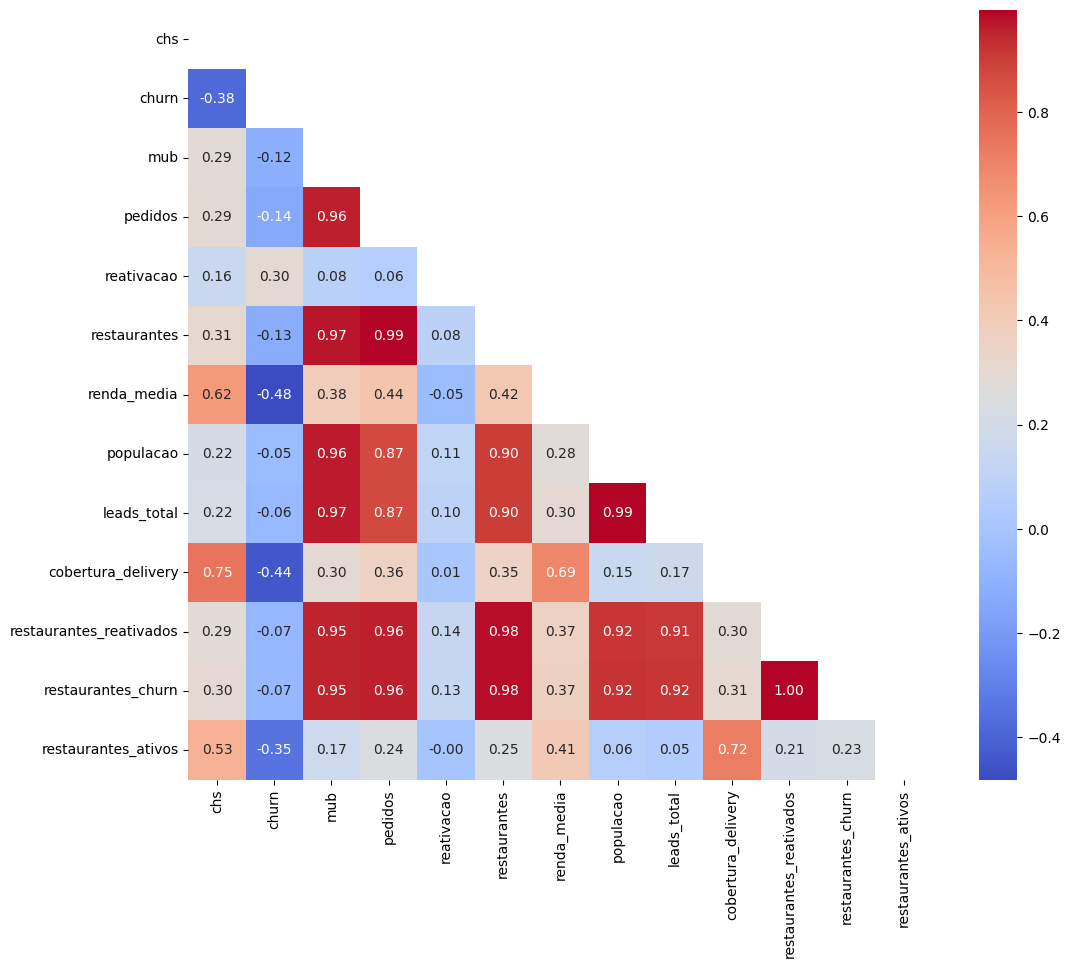

In [392]:
# Selecting only numerical variables
df_num = df_median[['chs', 'churn', 'mub', 'pedidos',
                    'reativacao', 'restaurantes', 'renda_media', 'populacao', 'leads_total', 'cobertura_delivery',
                    'restaurantes_reativados', 'restaurantes_churn', 'restaurantes_ativos']]


# Calculate the correlation matrix
corr_matrix = df_num.corr()

# Create a mask for the off-diagonal elements
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plotting the correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('')
plt.show()

        Plot to compare chs with the most correlated variables

In [393]:

import plotly.express as px

# Criar um gráfico facetado
fig = px.scatter(df_median, 
                 x=['cobertura_delivery', 'restaurantes_ativos'], 
                 y='chs', 
                 facet_row='variable', 
                 hover_data=['cidade', 'uf', 'region'], 
                 size_max=300, 
                 title='Scatter Plot de CHS vs. Variáveis')

# Personalizar o layout
fig.update_layout(
    legend_title='',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.1,
        xanchor='left',
        x=0
    )
)

# Exibir o gráfico
fig.show()


> Passo 3: Criação de uma segmentação

In [394]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Select relevant features for clustering (exclude categorical and identifier variables)
features = df_median[['chs', 'churn', 'mub', 'pedidos', 'reativacao', 'restaurantes', 
                      'renda_media', 'populacao', 'leads_total', 'restaurantes_reativados', 
                      'restaurantes_churn', 'restaurantes_ativos']]

# Handle missing or infinite values
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)

# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [395]:
features.shape

(529, 12)

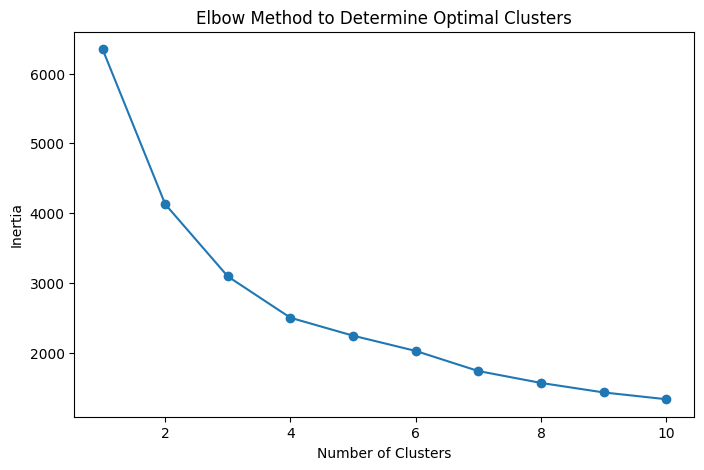

In [396]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
cluster_range = range(1, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [397]:
# Perform KMeans Clustering with the optimal number of clusters (choose k from the elbow point)
k_optimal = 4  # Adjust based on the elbow point
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans.fit(features_scaled)

# Add cluster labels to the original data
df_median['cluster'] = kmeans.labels_

# Analyze cluster centroids
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                         columns=features.columns)

        Table to summarise clusters information

In [399]:
aggregation_cluster = df_median.groupby('cluster').agg({'cidade':'count',
                                                        'populacao':'median',
                                                        'renda_media':'median',
                                                        'mub':'median',
                                                        'pedidos':'median',
                                                        'restaurantes':'median'}).reset_index()

aggregation_cluster = aggregation_cluster.apply(lambda x: x.apply(lambda y: '{:,.0f}'.format(y).replace(',', '.')))

aggregation_cluster

,cluster,cidade,populacao,renda_media,mub,pedidos,restaurantes
0,0,279,123.610,1.189,8.316,21.077,180
1,1,3,5.791.611,1.807,438.506,1.612.823,8.244
2,2,217,73.316,806,1.321,2.498,38
3,3,30,784.868,1.478,68.248,263.524,1.370


        Performing PCA to reduce dimensionality of dataset

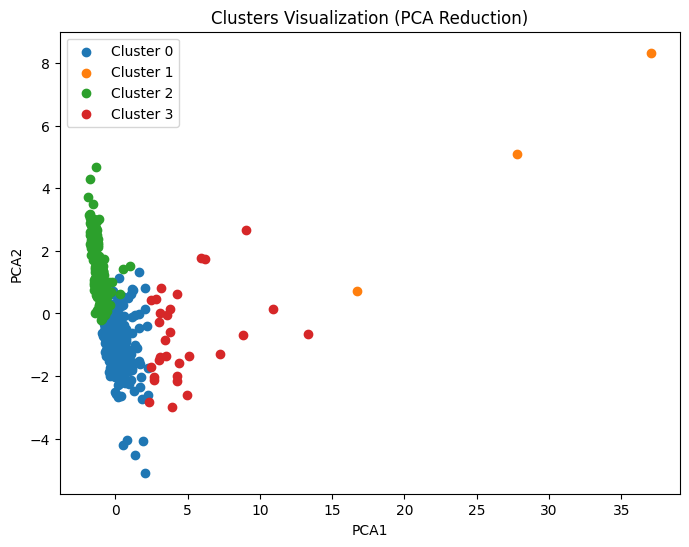

In [400]:
# Optional: Use PCA for dimensionality reduction to visualize clusters
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Add PCA components to the dataset for visualization
df_median['PCA1'] = features_pca[:, 0]
df_median['PCA2'] = features_pca[:, 1]

# Visualize clusters
plt.figure(figsize=(8, 6))
for cluster in range(k_optimal):
    cluster_data = df_median[df_median['cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

plt.title('Clusters Visualization (PCA Reduction)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

    Boxplot of % de restaurantes_ativos per region of cluster 0

In [401]:
mf.boxplot_table_plotly(df=df_median, cluster=0)

* 19 cidades do CENTRO-OESTE, tem renda média R$ 300 maior que a média de cidades do NORDESTE, mesmo assim tem um % de ativação 1pp abaixo.
* SUL, com 4,8pp médio de restaurantes ativados, fica abaixo do SUDESTE, embora tenha à segunda maior renda, ficando atrás apenas do CENTRO-OESTE.
* Direcionamento para alcançar target: aprendizado com cidades do Nordeste e Sudeste para alavancar outras regiões. Estimular ativação de categorias estratégicas.
___

    Boxplot of % de Restaurantes ativos per region of cluster 1

In [402]:
mf.boxplot_table_plotly(df=df_median, cluster=1)

* São Paulo, tem apenas 2.9% de restaurantes ativos, ficando atrás do Rio de Janeiro que tem a mesma renda e 4.9% de restaurantes ativos. SP também tem à menor cobertura de delivery, 6.9%.
* Brasília, tem à maior renda, a maior taxa de restaurantes ativos e de cobertura de delivery, 7.2% e 10.7%, respectivamente.
* Direcionamento para alcançar target: aprendizado com serviços prestados no RJ (renda média parecida) para alavancar ativação em SP. 

___

In [403]:
mf.boxplot_table_plotly(df=df_median, cluster=2)

* 102 cidades do Nordeste, região com a menor renda do grupo, são destaque com a segunda maior taxa de restaurantes ativos.
* O Sul, região de maior renda, têm à segunda menor taxa de restaurantes ativos do Cluster 2.
* Direcionamento para alcançar target: aprendizado com cidades do Nordeste. Entendimento mais aprofundado. Recebem mais incentivos?
___

In [404]:
mf.boxplot_table_plotly(df=df_median, cluster=3)

* Sudeste tem 15 cidades com uma boa taxa média de restaurantes ativos. Compõe metrópoles de alta densidade: Santo André, Sorocaba, São Bernardo.
* Taxa de ativação média nas cidades do Sudeste do Cluster 3, maior que a de Brasília, cidade mais rica, no Cluster 1.
* Direcionamento para alcançar target: pode ser utilizado como aprendizado para alavancar resultados da cidade de São Paulo (primordialmente).
___

> Modelo de Regressão Linear

    To increase restaurantes_ativos, we should impact the following business variables

$$
restaurantes\_ativos = \beta_0 + \beta_1 \cdot chs + \beta_2 \cdot churn\ + \beta_3 \cdot reativacao\ + \beta_4 \cdot churn*reativacao\ + \varepsilon
$$

In [406]:
import pandas as pd
import statsmodels.api as sm

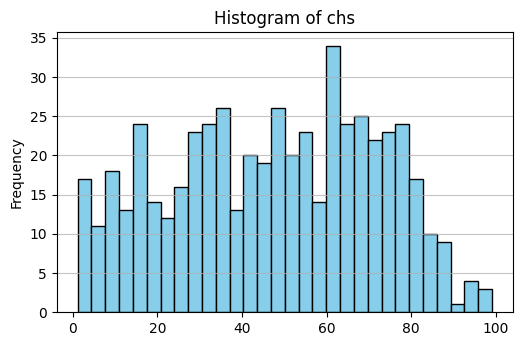

In [416]:
# Change the x parameter to see the distributin for other variables
mf.plot_hist(df=df_median, x='chs')

Das 4 variáveis em questão, apenas cobertura_delivery não aparenta ter uma distribuição normal
___

        Selecionando variáveis relevantes e rodando a regressão linear

In [ ]:
# Define dependent variable (target) and independent variables
target = 'restaurantes_ativos'
independent_vars = ['chs', 'cobertura_delivery', 'renda_media', 'churn', 'mub',
                    'pedidos', 'reativacao', 'populacao', 'leads_total']

# Dropping high correlated 'independent' variables and other variables which the company can not impact
independent_vars = ['chs', 'churn', 'reativacao']

# Transformação logarítmica
# A transformação logarítmica é uma das mais comuns para variáveis com assimetria positiva e concentrações à esquerda.
# Ela reduz o impacto dos valores mais altos e aproxima a distribuição da normalidade.
X = df_median[independent_vars]

# X['cobertura_delivery'] = np.log1p(X['cobertura_delivery'])
# X['chs'] = np.log1p(X['chs'])

# Including a combination between churn and reativacao as they have counterintuitive signal in regression above, 
# and it can be due correlation process.
X['churn_reativacao'] = X['churn']*X['reativacao']

# Standardize the data
scaler = StandardScaler()
X[['chs', 'churn_reativacao']] = scaler.fit_transform(X[['chs', 'churn_reativacao']])

y = df_median[target]

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Display regression summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     restaurantes_ativos   R-squared:                       0.310
Model:                             OLS   Adj. R-squared:                  0.305
Method:                  Least Squares   F-statistic:                     58.86
Date:                 Tue, 17 Dec 2024   Prob (F-statistic):           4.92e-41
Time:                         16:28:16   Log-Likelihood:                -1200.2
No. Observations:                  529   AIC:                             2410.
Df Residuals:                      524   BIC:                             2432.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.8668      1.092      5.375      0.000       3.722       8.011
chs                  1.3468      0.119     11.355      0.000       1.114       1.580
churn               -0.1448      0.056     -2.598      0.010      -0.254      -0.035
reativacao          -0.0412      0.234     -0.176      0.861      -0.502       0.419
churn_reativacao    -0.0341      0.388     -0.088      0.930      -0.797       0.729
==============================================================================
Omnibus:                       63.226   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.819
Skew:                           0.861   Prob(JB):                     1.40e-19
Kurtosis:                       3.986   Cond. No.                         118.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

churn has coerent signal, but they are no statiscally significant. 
___

        Ponderação do crescimento necessário, pela população de cada cluster

In [441]:
# 1. Define o aumento necessário em restaurantes_ativos (7% do valor médio)
increase_target = df_median['restaurantes_ativos'].median() * 0.07

# 2. Coeficiente da variável CHS no modelo ajustado
coefficient_chs = model.params['chs']

# 3. Calcula o crescimento total necessário em CHS para atingir a meta
total_growth_chs = increase_target / coefficient_chs

# 4. Agrupa os dados por cluster e calcula a soma da população
cluster_population = df_median.groupby('cluster')['populacao'].sum()

# 5. Calcula a proporção de população de cada cluster em relação ao total
population_proportion = cluster_population / cluster_population.sum()

# 6. Distribui o crescimento necessário de CHS proporcionalmente à população
required_growth_cluster = population_proportion * total_growth_chs

# 7. Exibe o crescimento necessário para cada cluster
print("Crescimento necessário de CHS por cluster (ponderado apenas pela população):")
pd.DataFrame(required_growth_cluster).reset_index()

Crescimento necessário de CHS por cluster (ponderado apenas pela população):


,cluster,populacao
0,0,0.081912
1,1,0.031460
2,2,0.033784
3,3,0.050346


        Media de chs atual

In [440]:
aggregation_cluster = df_median.groupby('cluster').agg({'cidade':'count',
                                                        'chs':'median'}).reset_index()

aggregation_cluster

,cluster,cidade,chs
0,0,279,62.1
1,1,3,73.2
2,2,217,24.2
3,3,30,73.4
